# Лабораторная работа №1. Регрессия

**Тема:** *Сравнение линейной регрессии, случайного леса (Random Forest Regressor), градиентного бустинга (XGBoost) на задаче регрессии.*

**Цели:**

- *Научиться строить, оптимизировать и оценивать регрессионные модели.*
- *Понять, как интерпретировать важность признаков (feature importance).*
- *Понять, как увеличивать кол-во признаков (feature tuning).*
- *Исследовать влияние преобразований признаков (фичей), регуляризации и гиперпараметров.*

**Условия:**

- *numpy, pandas, scikit-learn, XGBoost*
- *выбрать датасет для 1-ой и 2-ой лабораторной работы*

**Пункты:**

1. Подготовка данных + Feature Tuning
2. Создание метрик
3. Базовая модель линейной регрессии
4. Улучшение линейной регрессии
5. Случайный лес регрессор
6. Feature Importance
7. Написание своих реализаций (классы)
8. Подведение итогов

## О команде

| Фамилия И.О.        | Группа | Роль в команде | Что делал                    |
|---------------------|--------|----------------|------------------------------|
| Шароченкова С.М.        | 309    | Solo way       | Всё сам                      |

 Датасет: [titanic](https://www.kaggle.com/datasets/yasserh/titanic-dataset)

## Описание датасета

The sinking of the Titanic is one of the most infamous shipwrecks in history.

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone on board, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

In this challenge, we ask you to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).

---

### Таблица признаков

| №  | Признак                  | Тип данных     | Описание                                                                               |
| -- | ------------------------ | -------------- | -------------------------------------------------------------------------------------- |
| 1  | **PassengerId**        | int         | Идентификатор пассажира |
| 2  | **Survived**     | int          | Выжил или нет: 0 = нет, 1 = да     |
| 3  | **Pclass**          | int          | Класс билетов: 1 = 1 -й, 2 = 2 -й, 3 = 3 -й                           |
| 4  | **Name**       | str          | Имя пассажира                        |
| 5  | **Sex**            | str         | Пол              |
| 6  | **Age**  | int          | Возраст в годах                |
| 7  | **SibSp** | int          | Количество родственников / супругов на борту Титаника          |
| 8  | **Parch**              | int          | Количество родителей / детей на борту Титаника                               |
| 9  | **Ticket**                   | float          | Номер билета.                                |
| 10 | **Fare**            | float          | Цена билета  |
| 11 | **Cabin**              |         | Номер кабины                 |
| 12 | **Embarked**    | str | Порт посадки: C = Шербург, Q = Queenstown, S = Southampton                    |

## 0. Глобальная настройка проекта

In [1]:
RND_SEED = 21
USE_AUTO_POLY = True

## 1) Импорт библиотек

In [87]:
import os, warnings, inspect
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from scipy.stats import skew, kurtosis

from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.base import BaseEstimator, RegressorMixin

## 2) Конфигурация путей и параметров

In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
from pathlib import Path

drive_path = Path('https://drive.google.com/drive/u/1/my-drive')
drive.mount(str(drive_path))

file_path = drive_path / 'MyDrive' / 'lab1' / 'Titanic-Dataset.csv'
df = pd.read_csv(file_path)

TARGET = 'Survived'
TEST_SIZE = 0.25
RANDOM_STATE = 42

print('DATA_PATH =', DATA_PATH)
print('OUTPUT_DIR =', OUTPUT_DIR)
print('TARGET =', TARGET)

DATA_PATH = C:/Users/Sonya/lab11/Titanic-Dataset.csv
OUTPUT_DIR = C:/Users/Sonya/lab11/Titanic-Dataset.csvlab_outputs
TARGET = Survived


## 3) Загрузка данных и быстрый обзор

In [4]:
df = pd.read_csv(DATA_PATH)
print('Размер датасета:', df.shape)
display(df.head())

drop_cols = [c for c in ['PassengerId','Name','Ticket','Cabin'] if c in df.columns]
print('\nКолонки, которые будут исключены (идентификаторы):', drop_cols)


print('\nОписание столбцов и пропуски:')
display(df.info())
display(df.isnull().sum())

Размер датасета: (891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S



Колонки, которые будут исключены (идентификаторы): ['PassengerId', 'Name', 'Ticket', 'Cabin']

Описание столбцов и пропуски:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


None

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

### 3.1 Описательная статистика

In [5]:

display(df.describe())

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


**Вывод:**

1. Общая информация

    * **Размер датасета**: 891 наблюдение (пассажиры Титаника).
    * **Целевая переменная (Survived )**: принимает значения от 0 = не выжил до 1 = выжил.
    
        -> Значит, Выжили: ≈ 38%, не выжили: ≈ 62%..
        -> Выживших заметно меньше, чем погибших → **ДИСБАЛАНС КЛАССОВ**.

2. Категориальные признаки

    * **Sex** (пол):

        * Мужчины составляют ≈ 65%, женщины ≈ 35%.
        * Женщины выживали чаще (исторический факт: «сначала женщины и дети»).

    * **Pclass** (класс каюты):

        * 1-й класс — более дорогие билеты, ≈ 24% пассажиров.

        * 3-й класс — более дешёвые, ≈ 55%.

        * Выживаемость в 1-м классе намного выше, чем в 3-м.

    * **Embarked** (порт посадки):

        * C = Cherbourg, Q = Queenstown, S = Southampton.

        * Southampton — основной порт (≈ 72%).

3. Числовые признаки

    * **Age** (возраст):

        * Средний возраст ≈ 29 лет. Диапазон 0.42 – 80 лет.
        * Есть пропуски (≈ 20%).
        * Младенцы и дети имели больше шансов на выживание.

    * **Fare** (стоимость билета):

        * Среднее ≈ 32, медиана ≈ 14.
        * Сильный разброс (максимум > 500).
        * Выбросы (очень дорогие билеты).
        * Тариф сильно зависит от класса и влияет на вероятность выживания.

    * **Parch** (родители, дети на борту):

        * Большинство (≈ 76%) без семьи.
        * Семьи из 2–3 человек имели лучший шанс на выживание.

### 3.2 Анализ целевой переменной (распределение, скошенность)

In [6]:
y = df[TARGET]
print(y.describe())

count    891.000000
mean       0.383838
std        0.486592
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: Survived, dtype: float64


<Axes: xlabel='Pclass', ylabel='Survived'>

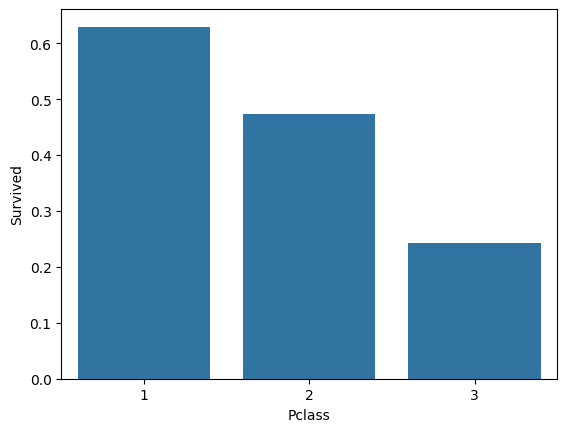

In [7]:
sns.barplot(x='Pclass', y='Survived', data=df, ci=None)

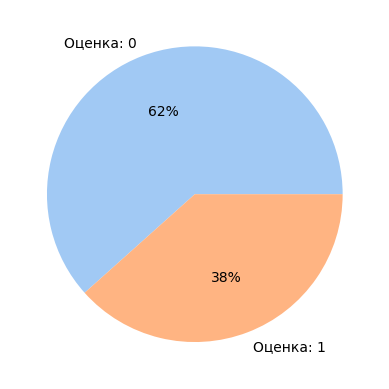

In [8]:
def draw_pie_plot(df: pd.DataFrame, column_name: str):
    explore_column = df[column_name]
    explore_column_normal = list(zip(
        [f'Оценка: {q}' for q in explore_column.value_counts().index],
        explore_column.value_counts(normalize=True)
    ))

    label, params = zip(*explore_column_normal)

    colors = sns.color_palette('pastel')[0:len(params)]
    plt.pie(params, labels=label, colors=colors, autopct='%.0f%%')
    plt.show()
draw_pie_plot(df, 'Survived')

### 3.3 Корреляционная матрица числовых признаков

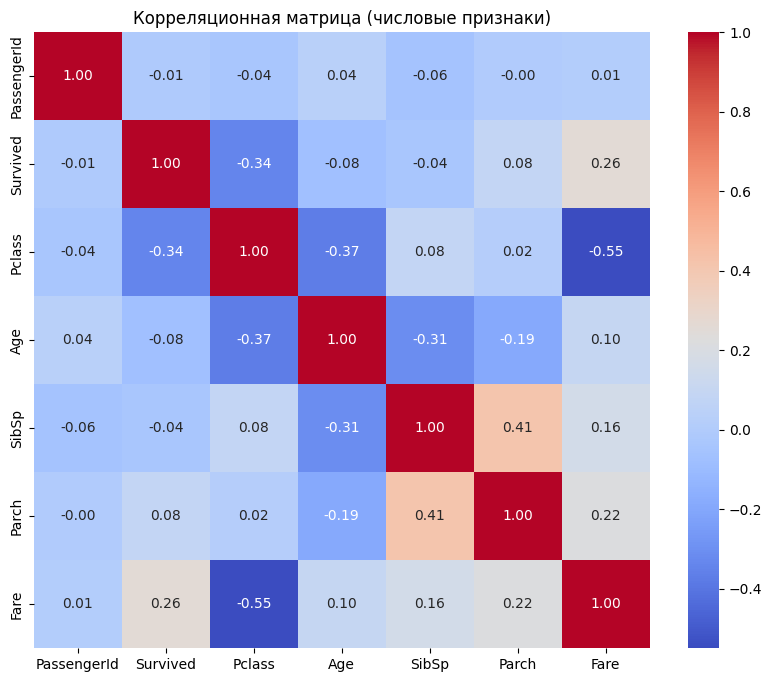

In [9]:

num_df = df.select_dtypes(include=['int64','float64'])
plt.figure(figsize=(10,8))
sns.heatmap(num_df.corr(), annot=True, fmt='.2f', cmap='coolwarm', square=True)
plt.title('Корреляционная матрица (числовые признаки)')
plt.show()

In [10]:
df_linear = df.copy()

In [11]:
numeric_df = df_linear.select_dtypes(include=['int64', 'float64'])

skew_values = numeric_df.skew()

skew_values_hard = skew_values[abs(skew_values) > 0.5]
print(skew_values_hard)

skew_columns_hard = list(skew_values_hard.index)
print(f'Скошенные столбцы: {skew_columns_hard}')


Pclass   -0.630548
SibSp     3.695352
Parch     2.749117
Fare      4.787317
dtype: float64
Скошенные столбцы: ['Pclass', 'SibSp', 'Parch', 'Fare']


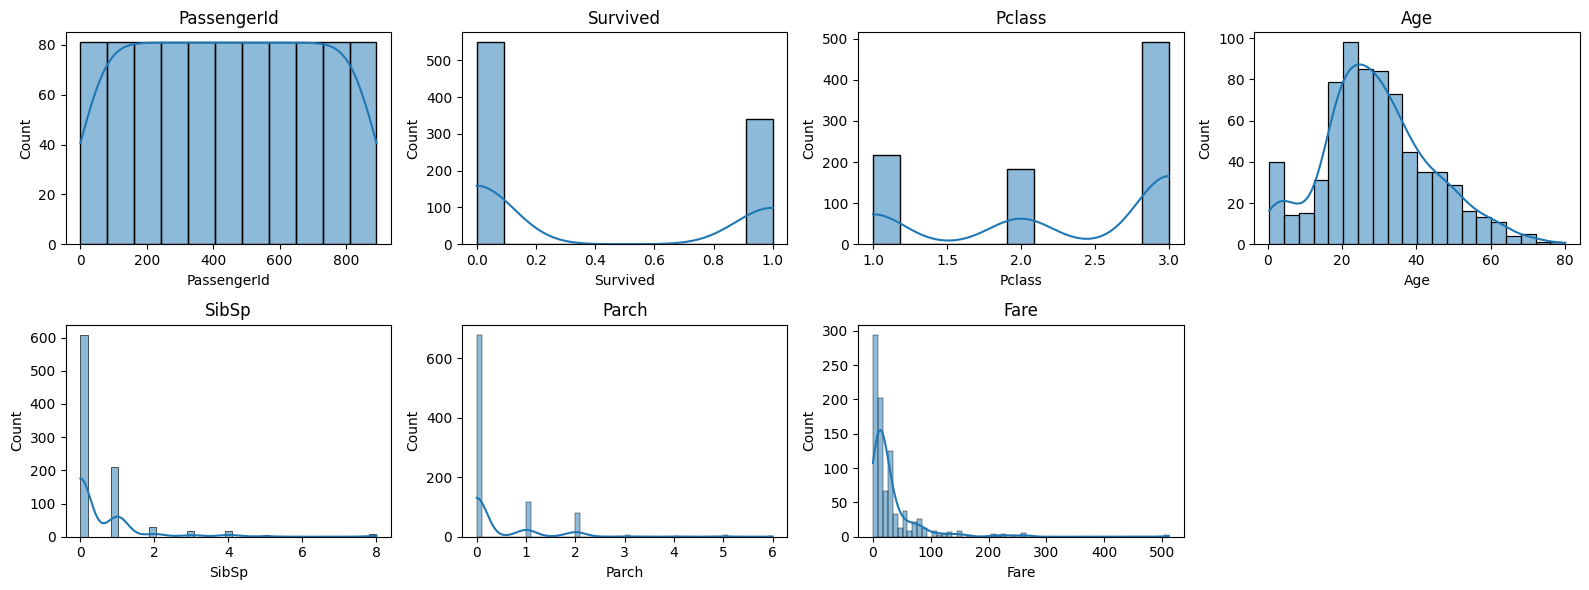

In [12]:
import math

def draw_skew(df: pd.DataFrame, n_cols=4):
    float_cols = df.select_dtypes(include=['int64', 'float64']).columns
    n_rows = math.ceil(len(float_cols) / n_cols)

    fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*3))
    axs = axs.flatten()  # делаем одномерным массивом для удобства

    for i, col in enumerate(float_cols):
        sns.histplot(df[col], kde=True, ax=axs[i])
        axs[i].set_title(f'{col}')

    # Если графиков меньше, чем ячеек в сетке, скрываем лишние
    for j in range(i+1, len(axs)):
        axs[j].set_visible(False)

    plt.tight_layout()
    plt.show()


draw_skew(df_linear)

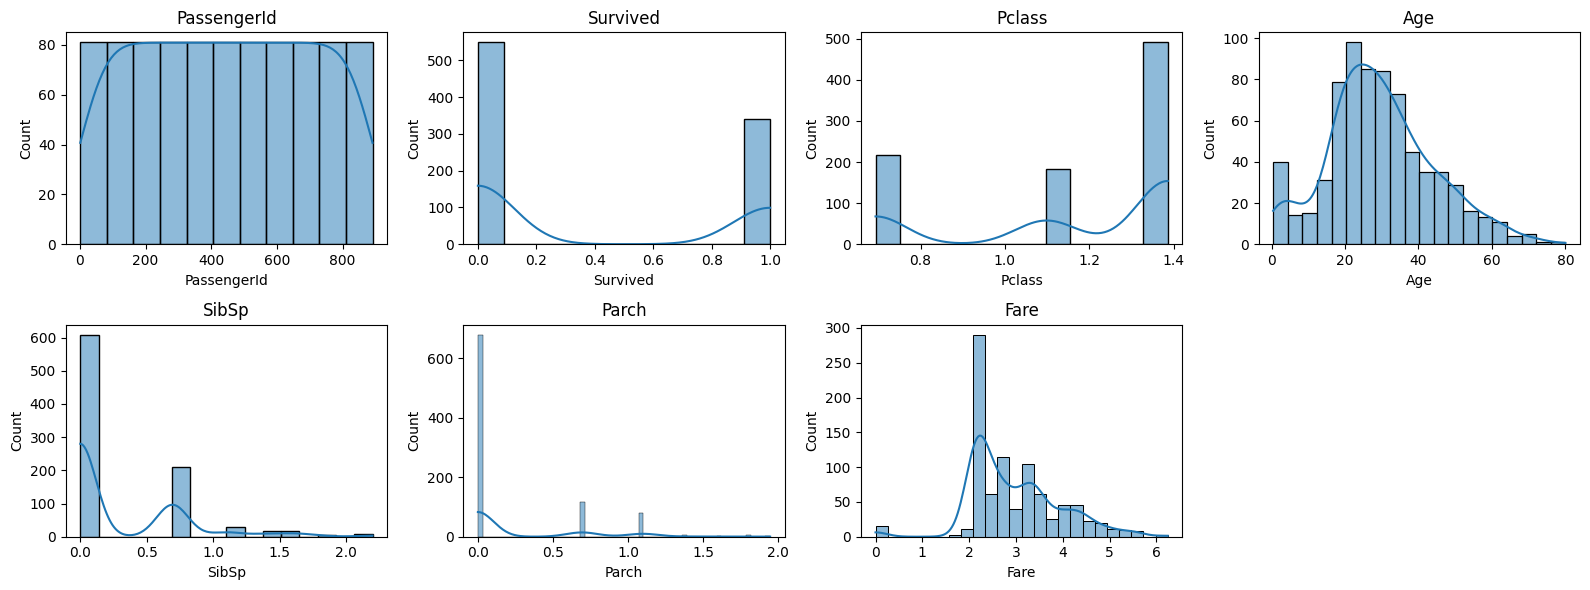

In [13]:
def prepare_skew(df: pd.DataFrame, columns: list[str]):
    for col in columns:
        df[col] = np.log1p(df[col])
    return df

df_linear = prepare_skew(df = df_linear, columns = skew_columns_hard)

draw_skew(df_linear)

In [14]:
USE_AUTO_POLY = False 

if not USE_AUTO_POLY:
    # --- Ручками---

    # Квадрат и корень возраста
    df_linear['Age_squared'] = df_linear['Age'] ** 2
    df_linear['Age_sqrt'] = df_linear['Age'] ** 0.5

    # Взаимодействия: количество родственников
    df_linear['Family_size'] = df_linear['SibSp'] + df_linear['Parch']
    df_linear['Is_alone'] = (df_linear['Family_size'] == 0).astype(int)

    # Взаимодействие: класс * стоимость билета
    df_linear['Class_Fare'] = df_linear['Pclass'] * df_linear['Fare']

    # Отношение стоимости билета к количеству родственников (если есть)
    df_linear['Fare_per_person'] = df_linear['Fare'] / (df_linear['Family_size'] + 1)

    # Логарифм стоимости билета (сглаживает выбросы)
    df_linear['Fare_log'] = np.log1p(df_linear['Fare'])

else:
    # --- Автоматическое создание полиномиальных признаков ---
    from sklearn.preprocessing import PolynomialFeatures

    # Выбираем только числовые признаки
    num_features = ['Age', 'SibSp', 'Parch', 'Fare']

    X_num = df_linear[num_features]

    # Генератор полиномиальных признаков (степень = 2)
    poly = PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)

    X_poly = poly.fit_transform(X_num)

    # Получаем имена новых признаков
    feature_names = poly.get_feature_names_out(num_features)

    # Превращаем обратно в DataFrame
    df_poly = pd.DataFrame(X_poly, columns=feature_names, index=df_linear.index)

    # Объединяем с исходным DataFrame
    df_linear = pd.concat([df_linear, df_poly], axis=1)

print("Форма данных после Feature Engineering:", df_linear.shape)

Форма данных после Feature Engineering: (891, 19)


Age_squared, Age_sqrt → чтобы уловить нелинейные эффекты возраста.

Family_size, Is_alone → важный социальный фактор (одиночные пассажиры выживали реже).

Class_Fare → взаимодействие между социальным статусом (классом) и богатством (стоимость билета).

Fare_per_person → билет, делённый на семью → пассажиры с большим семейством чаще платили меньше.

Fare_log → нормализация распределения тарифа (избавление от выбросов)

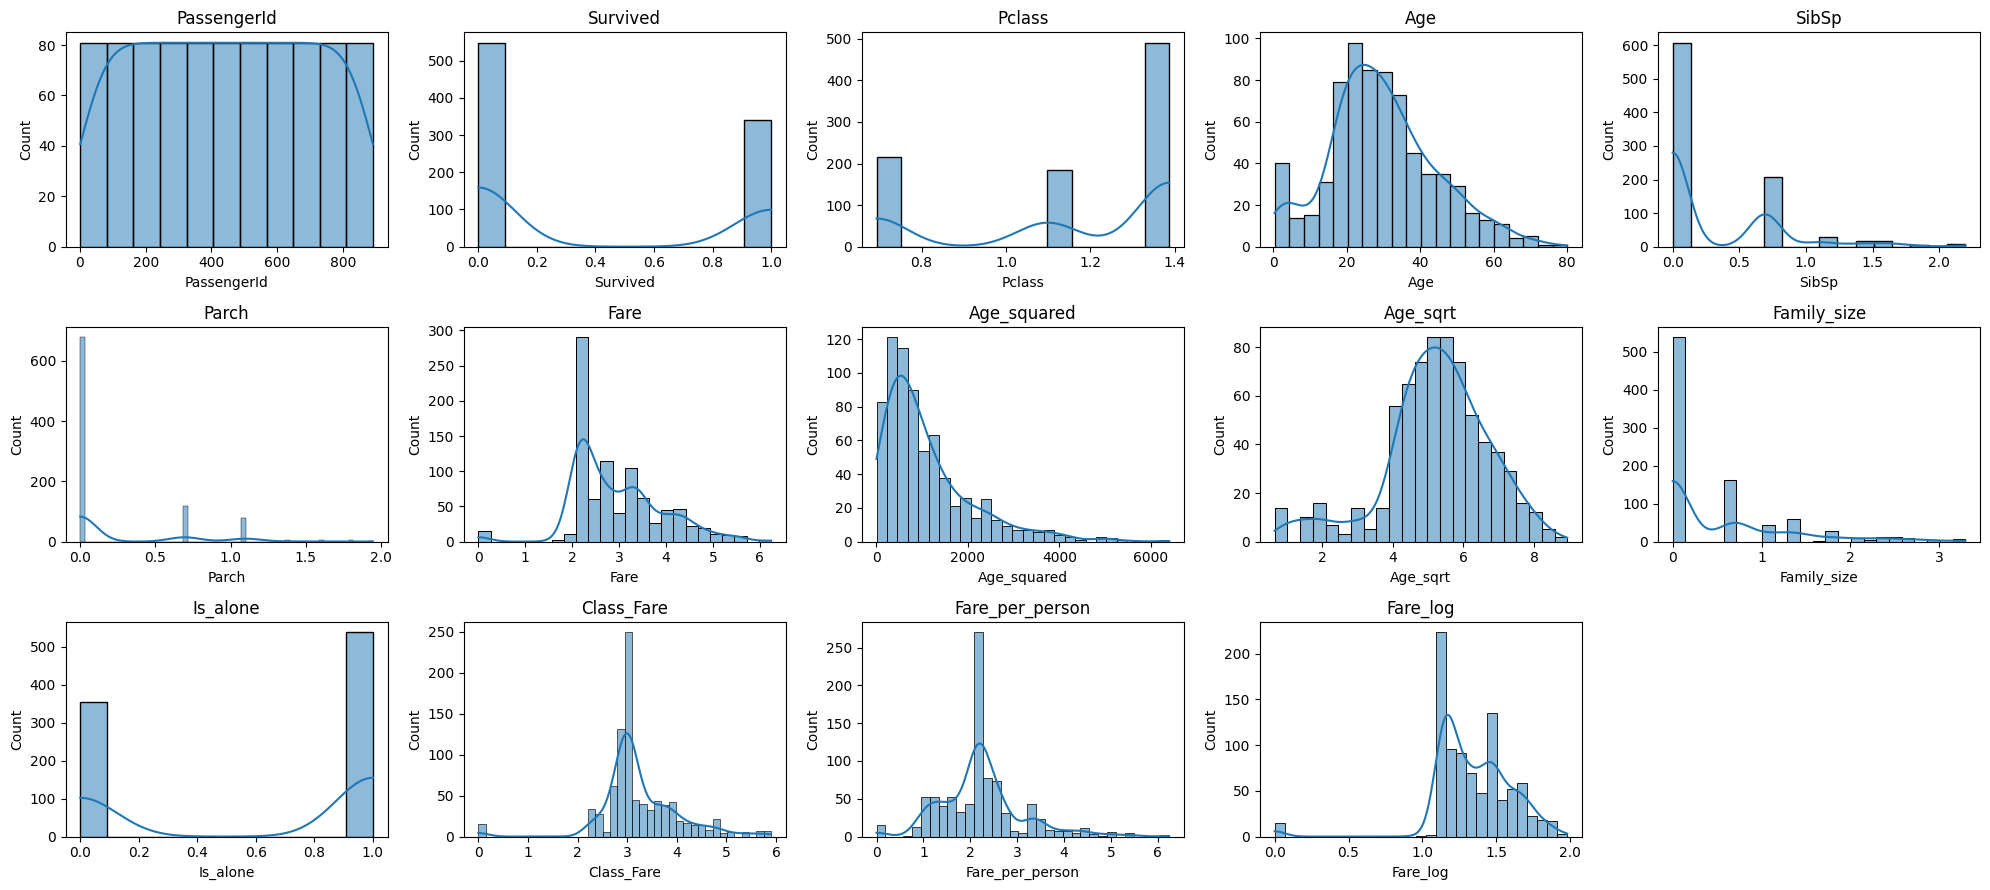

In [15]:
if not USE_AUTO_POLY:
    draw_skew(df_linear, 5)

## Выбросы и создание вариантов датасета

In [16]:
q1 = y.quantile(0.25)
q3 = y.quantile(0.75)
iqr = q3 - q1
lower = q1 - 1.5*iqr
upper = q3 + 1.5*iqr
outliers_mask = (y < lower) | (y > upper)
print(f'IQR границы: lower={lower:.3f}, upper={upper:.3f}')
print('Число выбросов в таргете:', outliers_mask.sum())

drop_cols = [c for c in ['PassengerId','Name','Ticket','Cabin'] if c in df.columns]
X_full = df.drop(columns=drop_cols+[TARGET], errors='ignore')
y_full = df[TARGET].copy()

X_raw = X_full.reset_index(drop=True)
y_raw = y_full.reset_index(drop=True)

X_log = X_raw.copy()
y_log = np.log1p(y_raw)

X_no_out = X_raw.loc[~outliers_mask].reset_index(drop=True)
y_no_out = y_raw.loc[~outliers_mask].reset_index(drop=True)

print('Размеры: raw=', X_raw.shape, 'no_out=', X_no_out.shape)

IQR границы: lower=-1.500, upper=2.500
Число выбросов в таргете: 0
Размеры: raw= (891, 7) no_out= (891, 7)


## Предобработка

In [17]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import inspect

num_cols = X_raw.select_dtypes(include=['int64','float64']).columns.tolist()
cat_cols = X_raw.select_dtypes(include=['object','category']).columns.tolist()
print('num_cols =', num_cols)
print('cat_cols =', cat_cols)

sig = inspect.signature(OneHotEncoder.__init__)
if 'sparse' in sig.parameters:
    ohe_kwargs = {'sparse': False}
else:
    ohe_kwargs = {'sparse_output': False}

num_transform = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
cat_transform = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', **ohe_kwargs))
])

preprocessor = ColumnTransformer([
    ('num', num_transform, num_cols),
    ('cat', cat_transform, cat_cols)
], remainder='drop')


num_cols = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
cat_cols = ['Sex', 'Embarked']


### 5.1 Разделение Train/Test

In [18]:
from sklearn.model_selection import train_test_split

X_linear = df_linear.drop(columns=['Survived'])
y_linear = df_linear['Survived']

# Разделение выборки на test/train (20/80)
X_train_linear, X_test_linear, y_train_linear, y_test_linear = train_test_split(
    X_linear, y_linear, test_size=0.2, random_state=42
)

In [19]:
X_train_linear_scaled = preprocessor.fit_transform(X_train_linear)
X_test_linear_scaled = preprocessor.transform(X_test_linear)

print("Размер X_train после трансформации:", X_train_linear_scaled.shape)
print("Размер X_test после трансформации:", X_test_linear_scaled.shape)

Размер X_train после трансформации: (712, 10)
Размер X_test после трансформации: (179, 10)


#### 1.3.2 Random Forest Regressor

In [20]:
df_forest = df.copy()

In [21]:
# Размер семьи
df_forest['Family_size'] = df_forest['SibSp'] + df_forest['Parch']

# Признак: пассажир один?
df_forest['Is_alone'] = (df_forest['Family_size'] == 0).astype(int)

# Стоимость билета на человека
df_forest['Fare_per_person'] = df_forest['Fare'] / (df_forest['Family_size'] + 1)

# Логарифм тарифа (устранение выбросов)
df_forest['Fare_log'] = np.log1p(df_forest['Fare'])

# Взаимодействие: класс * стоимость билета
df_forest['Class_Fare'] = df_forest['Pclass'] * df_forest['Fare']

In [22]:
X_forest = df_forest.drop(columns=['Survived'])
y_forest = df_forest['Survived']

X_train_forest, X_test_forest, y_train_forest, y_test_forest = train_test_split(
    X_forest, y_forest, test_size=0.2, random_state=RND_SEED
)

#### 1.3.3 XGBoost

In [23]:
df_xgboost = df.copy()

In [24]:
# Соотношения
df_xgboost['Family_size'] = df_xgboost['SibSp'] + df_xgboost['Parch']
df_xgboost['Is_alone'] = (df_xgboost['Family_size'] == 0).astype(int)
df_xgboost['Age_squared'] = df_xgboost['Age'] ** 2
df_xgboost['Age_sqrt'] = np.sqrt(df_xgboost['Age'])

# Интеракции
df_xgboost['Fare_per_person'] = df_xgboost['Fare'] / (df_xgboost['Family_size'] + 1)

# Логарифмы (чтобы уменьшить эффект хвостов распределения)
df_xgboost['Fare_log'] = np.log1p(df_xgboost['Fare'])

In [25]:
X_xgboost = df_xgboost.drop(columns=['Survived'])
y_xgboost = df_xgboost['Survived']

X_train_xgboost, X_test_xgboost, y_train_xgboost, y_test_xgboost = train_test_split(
    X_xgboost, y_xgboost, test_size=0.2, random_state=RND_SEED
)

## 2. Создание метрик

1. **MSE (Mean Squared Error)** – средняя квадратичная ошибка:

$$
\text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
$$

* Чем меньше, тем лучше.
* Чувствительна к выбросам (квадрат ошибки усиливает влияние больших отклонений).

2. **RMSE (Root Mean Squared Error)** – корень из MSE:

$$
\text{RMSE} = \sqrt{\text{MSE}}
$$

* В тех же единицах, что и целевая переменная.
* Легче интерпретировать.

3. **MAE (Mean Absolute Error)** – средняя абсолютная ошибка:

$$
\text{MAE} = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|
$$

* Менее чувствительна к выбросам, показывает «среднюю ошибку» в исходных единицах.

4. **R² (коэффициент детерминации)**:

$$
R^2 = 1 - \frac{\sum (y_i - \hat{y}_i)^2}{\sum (y_i - \bar{y})^2}
$$

* 1 → идеальное предсказание, 0 → модель не лучше среднего, <0 → хуже среднего.

In [26]:
def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)

def rmse(y_true, y_pred):
    return np.sqrt(mse(y_true, y_pred))

def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred))

def r2(y_true, y_pred):
    return 1 - (np.sum((y_true - y_pred) ** 2) / np.sum((y_true - np.mean(y_true)) ** 2))

def get_metrics(y_true, y_pred):
    return {
        'MSE': mse(y_true, y_pred),
        'RMSE': rmse(y_true, y_pred),
        'MAE': mae(y_true, y_pred),
        'R2': r2(y_true, y_pred)
    }


## 3. Базовая модель линейной регрессии (аналитическое решение)

In [27]:
# Создание линейной модели
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

In [28]:
# Обучение
lr.fit(X_train_linear_scaled, y_train_linear)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [29]:
# Прогонка и метрики
y_pred = lr.predict(X_test_linear_scaled)
lr_metrics = get_metrics(y_test_linear, y_pred)
lr_metrics

{'MSE': np.float64(0.13458105816560192),
 'RMSE': np.float64(0.3668529108043194),
 'MAE': np.float64(0.2854209406564887),
 'R2': np.float64(0.4450306712118337)}

## 4. Улучшенная версия линейной регрессии

In [30]:
from sklearn.linear_model import SGDRegressor

### 4.1. Градиентный спуск (симуляция)

In [31]:
# Создание линейной модели градиентного спуска
lr_gd = SGDRegressor(
    max_iter=2000,               # максимум итераций
    tol=1e-6,                    # остановка, когда улучшение < tol
    learning_rate='constant',  # тип изменения шага
    eta0=0.01,                   # стартовый шаг
    penalty='l2',                # регуляризация L2 (Ridge)
    shuffle=False,               # важный момент: не перемешиваем данные, чтобы был настоящий GD
    random_state=RND_SEED
)

In [32]:
# Обучение
lr_gd.fit(X_train_linear_scaled, y_train_linear)

,loss,'squared_error'
,penalty,'l2'
,alpha,0.0001
,l1_ratio,0.15
,fit_intercept,True
,max_iter,2000
,tol,1e-06
,shuffle,False
,verbose,0
,epsilon,0.1
,random_state,21


In [33]:
# Прогонка и метрики
y_pred = lr_gd.predict(X_test_linear_scaled)
lr_gd_metrics = get_metrics(y_test_linear, y_pred)
lr_gd_metrics

{'MSE': np.float64(0.13947718736924022),
 'RMSE': np.float64(0.37346644744774626),
 'MAE': np.float64(0.27061178764714544),
 'R2': np.float64(0.42484059710452693)}

### 4.2. Стохастический градиентный спуск

In [34]:
# Инициализация модели
lr_sgd = SGDRegressor(
    max_iter=2000,                # максимум итераций
    tol=1e-6,                     # остановка, когда улучшение < tol
    learning_rate='invscaling',   # тип изменения шага
    eta0=0.01,                    # стартовый шаг
    penalty='l1',                 # регуляризация L2 (Ridge)
    random_state=RND_SEED
)

In [35]:
# Обучение
lr_sgd.fit(X_train_linear_scaled, y_train_linear)

,loss,'squared_error'
,penalty,'l1'
,alpha,0.0001
,l1_ratio,0.15
,fit_intercept,True
,max_iter,2000
,tol,1e-06
,shuffle,True
,verbose,0
,epsilon,0.1
,random_state,21


In [36]:
# Прогонка и метрики
y_pred = lr_sgd.predict(X_test_linear_scaled)
lr_sgd_metrics = get_metrics(y_test_linear, y_pred)
lr_sgd_metrics

{'MSE': np.float64(0.13457529776238672),
 'RMSE': np.float64(0.3668450596128926),
 'MAE': np.float64(0.28358536124751743),
 'R2': np.float64(0.44505442527610906)}

### 4.3. Линейная модель с регуляризацией Rigde (L2)

In [37]:
# Инициализация модели
from sklearn.linear_model import Ridge
lr_ridge = Ridge(alpha=1.0)

In [38]:
# Обучение
lr_ridge.fit(X_train_linear_scaled, y_train_linear)

,alpha,1.0
,fit_intercept,True
,copy_X,True
,max_iter,None
,tol,0.0001
,solver,'auto'
,positive,False
,random_state,None


In [39]:
# Прогонка и метрики
y_pred = lr_ridge.predict(X_test_linear_scaled)
lr_ridge_metrics = get_metrics(y_test_linear, y_pred)
lr_ridge_metrics

{'MSE': np.float64(0.13458745368167419),
 'RMSE': np.float64(0.3668616274314802),
 'MAE': np.float64(0.28573183755753795),
 'R2': np.float64(0.4450042981448491)}

### 4.3. Линейная модель с регуляризацией Lasso (L1)

In [40]:
# Инициализация модели
from sklearn.linear_model import Lasso
lr_lasso = Lasso(alpha=0.01)

In [41]:
# Обучение
lr_lasso.fit(X_train_linear_scaled, y_train_linear)

,alpha,0.01
,fit_intercept,True
,precompute,False
,copy_X,True
,max_iter,1000
,tol,0.0001
,warm_start,False
,positive,False
,random_state,None
,selection,'cyclic'


In [42]:
# Прогонка и метрики
y_pred = lr_lasso.predict(X_test_linear_scaled)
lr_lasso_metrics = get_metrics(y_test_linear, y_pred)
lr_lasso_metrics

{'MSE': np.float64(0.13741405479438584),
 'RMSE': np.float64(0.370694017748312),
 'MAE': np.float64(0.3017324989777075),
 'R2': np.float64(0.4333482973401652)}

### 4.4. Линейная модель с регуляризацией ElasticNet (комбинация L1+L2)

In [43]:
# Инициализация модели
from sklearn.linear_model import ElasticNet
lr_enet = ElasticNet(alpha=0.01, l1_ratio=0.5)

In [44]:
# Обучение
lr_enet.fit(X_train_linear_scaled, y_train_linear)

,alpha,0.01
,l1_ratio,0.5
,fit_intercept,True
,precompute,False
,max_iter,1000
,copy_X,True
,tol,0.0001
,warm_start,False
,positive,False
,random_state,None
,selection,'cyclic'


In [45]:
# Прогонка и метрики
y_pred = lr_enet.predict(X_test_linear_scaled)
lr_enet_metrics = get_metrics(y_test_linear, y_pred)
lr_enet_metrics

{'MSE': np.float64(0.13573441734047337),
 'RMSE': np.float64(0.3684215212775624),
 'MAE': np.float64(0.2939140058083553),
 'R2': np.float64(0.4402745860996)}

## 4. Случайный лес регрессор

In [46]:
# Инициализация модели
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(
    n_estimators=200,      # количество деревьев
    max_depth=None,        # глубина деревьев
    random_state=RND_SEED,
    n_jobs=-1              # использовать все ядра процессора
)

In [47]:
rf_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("rf", RandomForestRegressor(
        n_estimators=200,
        max_depth=None,
        random_state=RND_SEED,
        n_jobs=-1
    ))
])

# Обучение
rf_pipeline.fit(X_train_forest, y_train_forest)

,steps,"[('preprocessor', ...), ('rf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [48]:
# Прогонка и метрики
y_pred = rf_pipeline.predict(X_test_forest)
rf_metrics = get_metrics(y_test_forest, y_pred)
rf_metrics

{'MSE': np.float64(0.13710219940498006),
 'RMSE': np.float64(0.37027314161977787),
 'MAE': np.float64(0.230001304449649),
 'R2': np.float64(0.43463428942921933)}

## 5. Градиентный бустинг (XGBoost)

In [49]:
# Инициализация модели
import xgboost
xgb = xgboost.XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=RND_SEED
)

In [50]:
xgb_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("xgb", xgboost.XGBRegressor(
        n_estimators=500,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=RND_SEED
    ))
])


# Обучение
xgb_pipeline.fit(X_train_xgboost, y_train_xgboost)

,steps,"[('preprocessor', ...), ('xgb', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [51]:
# Прогонка и метрики
y_pred = xgb_pipeline.predict(X_test_xgboost)
xgb_metrics = get_metrics(y_test_xgboost, y_pred)
xgb_metrics

{'MSE': np.float64(0.11873277251946657),
 'RMSE': np.float64(0.3445762216396636),
 'MAE': np.float64(0.22922550614561635),
 'R2': np.float64(0.5103839428190182)}

## 5. Feature Importance

### 5.1 Linear Regression

In [58]:
feature_names = preprocessor.get_feature_names_out()
print(f"Transformed features: {len(feature_names)}")
print("Sample names:", feature_names[:5])  # Первые 5 для проверки
if len(feature_names) != len(lr.coef_):
    raise ValueError(f"Несовпадение: {len(feature_names)} фич vs {len(lr.coef_)} коэффициентов. Проверьте fit модели.")

Transformed features: 10
Sample names: ['num__Pclass' 'num__Age' 'num__SibSp' 'num__Parch' 'num__Fare']


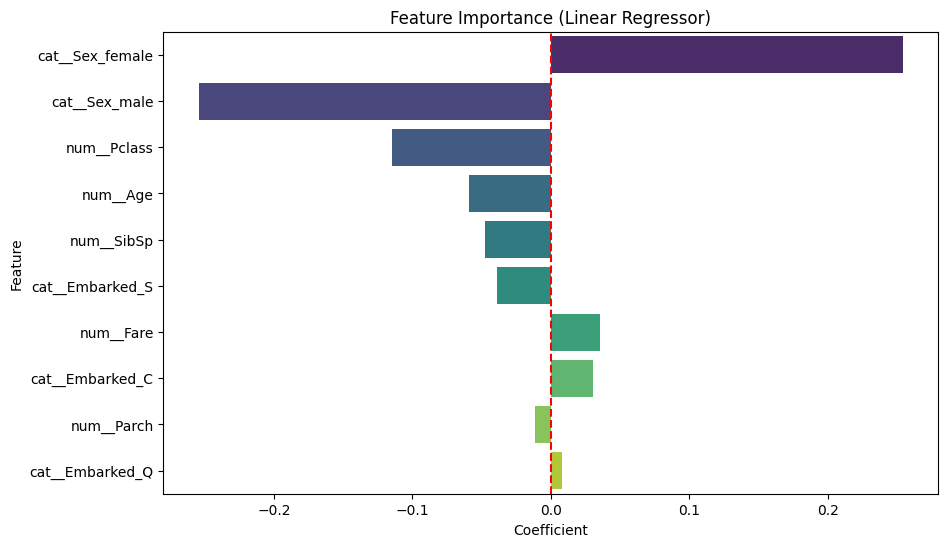

In [59]:
# Создаём DataFrame с правильными длинами
importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': lr.coef_
}).sort_values(by='Coefficient', key=abs, ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(
    x='Coefficient',
    y='Feature',
    data=importance,
    palette='viridis'
)
plt.axvline(0, color='red', linestyle='--')
plt.title('Feature Importance (Linear Regressor)')
plt.show()

### 5.2 Linear Regression (GD)

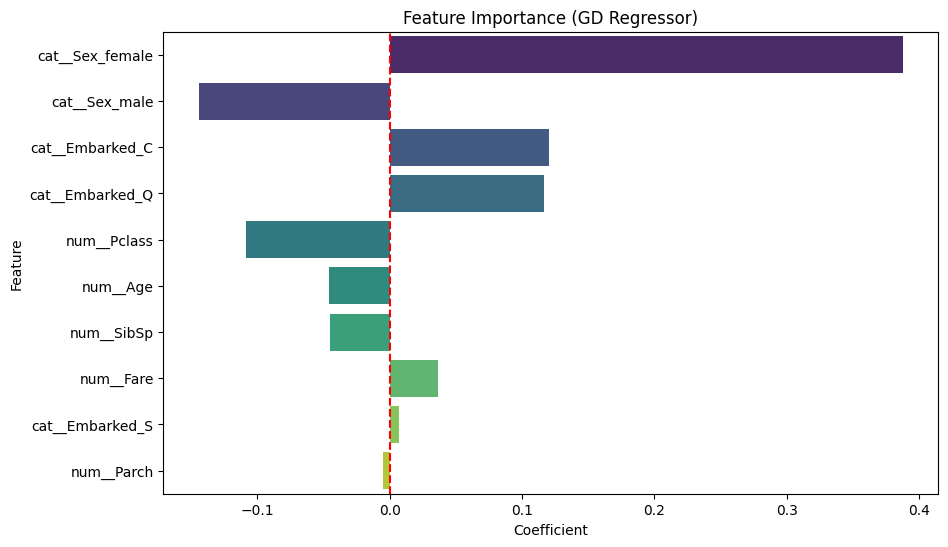

In [61]:
importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': lr_gd.coef_
}).sort_values(by='Coefficient', key=abs, ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(
    x='Coefficient',
    y='Feature',
    data=importance,
    palette='viridis'
)
plt.axvline(0, color='red', linestyle='--')
plt.title('Feature Importance (GD Regressor)')
plt.show()

### 5.3 Linear Regression (SGD)

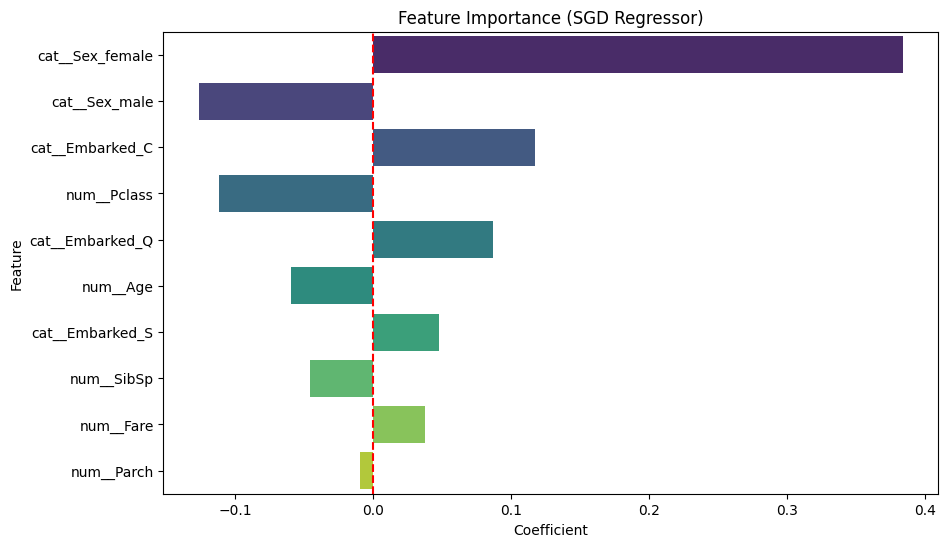

In [62]:
importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': lr_sgd.coef_
}).sort_values(by='Coefficient', key=abs, ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(
    x='Coefficient',
    y='Feature',
    data=importance,
    palette='viridis'
)
plt.axvline(0, color='red', linestyle='--')
plt.title('Feature Importance (SGD Regressor)')
plt.show()

### 5.4 Linear Regression (Rigde)

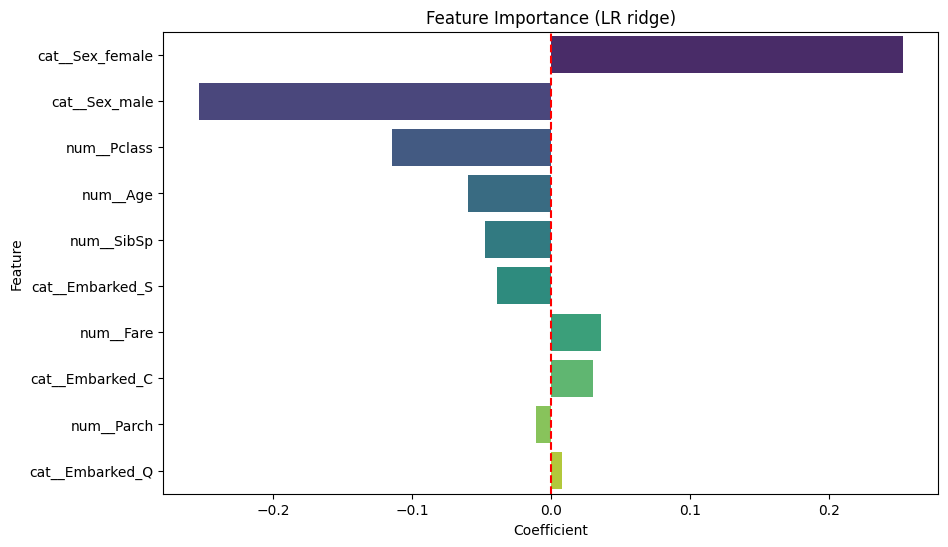

In [63]:
importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': lr_ridge.coef_
}).sort_values(by='Coefficient', key=abs, ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(
    x='Coefficient',
    y='Feature',
    data=importance,
    palette='viridis'
)
plt.axvline(0, color='red', linestyle='--')
plt.title('Feature Importance (LR ridge)')
plt.show()

### 5.5 Linear Regression (Lasso)

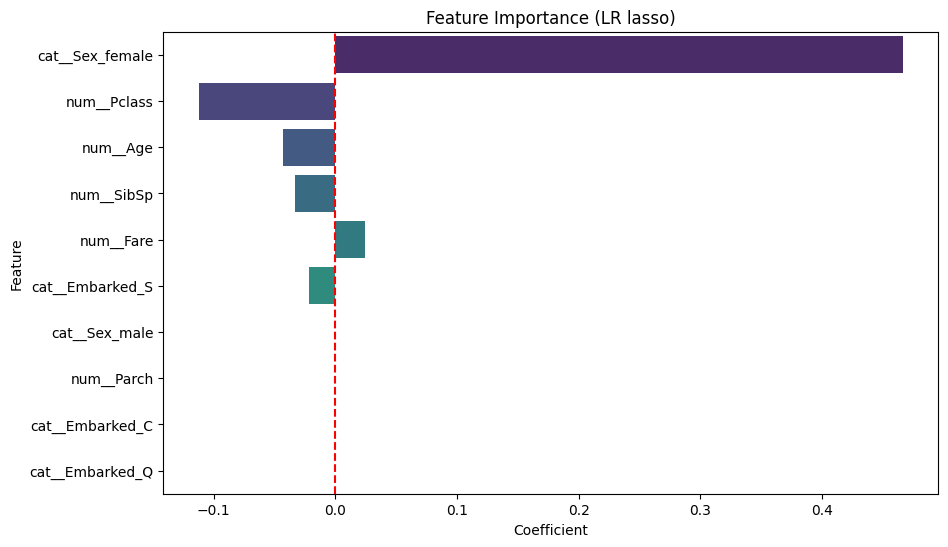

In [64]:
importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': lr_lasso.coef_
}).sort_values(by='Coefficient', key=abs, ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(
    x='Coefficient',
    y='Feature',
    data=importance,
    palette='viridis'
)
plt.axvline(0, color='red', linestyle='--')
plt.title('Feature Importance (LR lasso)')
plt.show()

### 5.6 Linear Regression (ElasticNet)

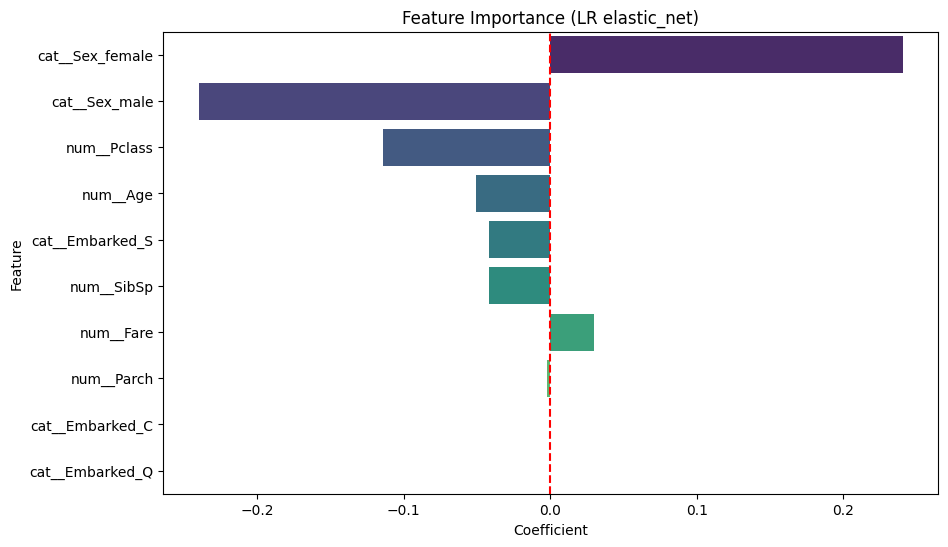

In [65]:
importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': lr_enet.coef_
}).sort_values(by='Coefficient', key=abs, ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(
    x='Coefficient',
    y='Feature',
    data=importance,
    palette='viridis'
)
plt.axvline(0, color='red', linestyle='--')
plt.title('Feature Importance (LR elastic_net)')
plt.show()

### 5.7 Random Forest

In [100]:
feature_names = preprocessor.get_feature_names_out()

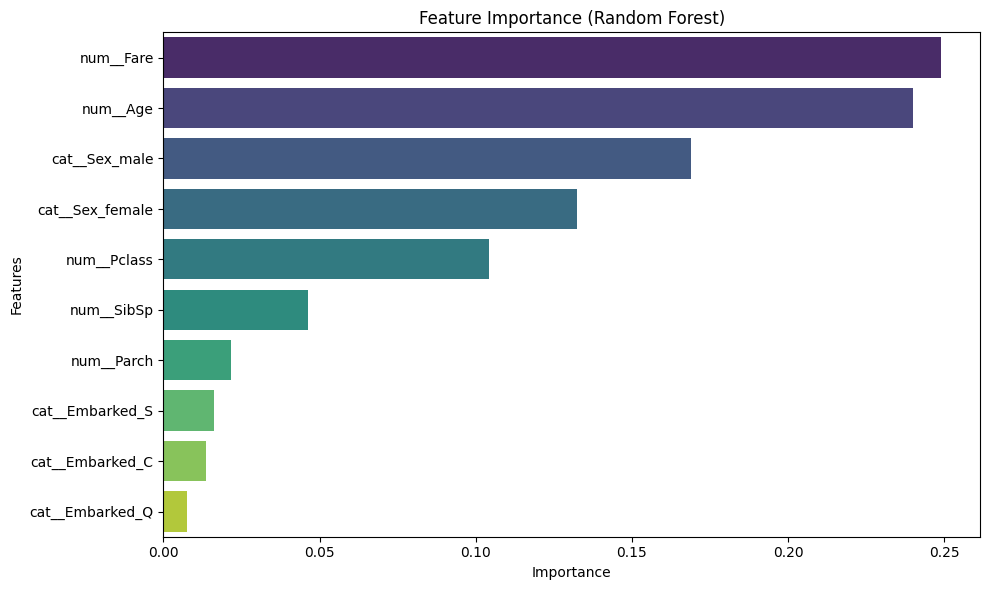

In [101]:
feature_importances = pd.Series(rf.feature_importances_, index=feature_names)
feature_importances = feature_importances.sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=feature_importances.values, y=feature_importances.index, palette='viridis')
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

### 5.6 XGBoost

In [111]:
import xgboost as xgb
xgb_model = xgb.XGBRegressor(n_estimators=100, random_state=RANDOM_STATE, verbosity=0)
xgb_model.fit(X_train_forest_scaled, y_train_forest)

feature_names = preprocessor.get_feature_names_out()

<Figure size 1000x600 with 0 Axes>

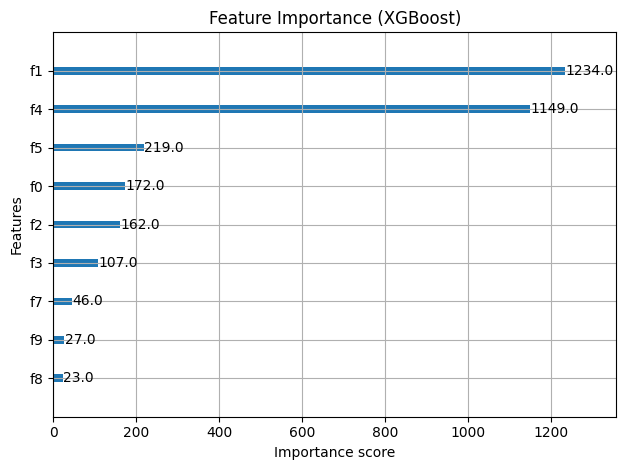

In [115]:
plt.figure(figsize=(10,6))
xgb.plot_importance(xgb_model, importance_type='weight', max_num_features=10)  # xgb. — модуль!
plt.title("Feature Importance (XGBoost)")
plt.tight_layout()
plt.show()

## 6) Обучение стандартных моделей и сбор метрик

In [116]:

from typing import Tuple, Dict

def evaluate_models_on_variant(X_df, y_series, variant_name):
    X_train, X_test, y_train, y_test = train_test_split(X_df, y_series, test_size=TEST_SIZE, random_state=RANDOM_STATE)
    pipe_models = {
        'LinearRegression': LinearRegression(),
        'Ridge': Ridge(alpha=1.0),
        'Lasso': Lasso(alpha=0.1),
        'RandomForest': RandomForestRegressor(n_estimators=100, random_state=RANDOM_STATE),
        'GradientBoosting': GradientBoostingRegressor(n_estimators=100, random_state=RANDOM_STATE)
    }

    results = []
    trained = {}
    for name, model in pipe_models.items():
        print(f'Обучаем {name} на варианте {variant_name}...')
        pipe = Pipeline([('pre', preprocessor), ('model', model)])
        pipe.fit(X_train, y_train)
        preds = pipe.predict(X_test)
        mse = mean_squared_error(y_test, preds)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, preds)
        r2 = r2_score(y_test, preds)
        results.append({'variant': variant_name, 'model': name, 'mse': mse, 'rmse': rmse, 'mae': mae, 'r2': r2})
        trained[name] = pipe
    return pd.DataFrame(results), trained

metrics_raw, trained_raw = evaluate_models_on_variant(X_raw, y_raw, 'raw_target')
metrics_log, trained_log = evaluate_models_on_variant(X_log, y_log, 'log_target')
metrics_noout, trained_noout = evaluate_models_on_variant(X_no_out, y_no_out, 'no_outliers')

metrics_df = pd.concat([metrics_raw, metrics_log, metrics_noout], ignore_index=True)
metrics_df.to_csv(os.path.join(OUTPUT_DIR, 'standard_models_metrics.csv'), index=False)
print('Метрики стандартных моделей сохранены в', os.path.join(OUTPUT_DIR, 'standard_models_metrics.csv'))
display(metrics_df)

Обучаем LinearRegression на варианте raw_target...
Обучаем Ridge на варианте raw_target...
Обучаем Lasso на варианте raw_target...
Обучаем RandomForest на варианте raw_target...
Обучаем GradientBoosting на варианте raw_target...
Обучаем LinearRegression на варианте log_target...
Обучаем Ridge на варианте log_target...
Обучаем Lasso на варианте log_target...
Обучаем RandomForest на варианте log_target...
Обучаем GradientBoosting на варианте log_target...
Обучаем LinearRegression на варианте no_outliers...
Обучаем Ridge на варианте no_outliers...
Обучаем Lasso на варианте no_outliers...
Обучаем RandomForest на варианте no_outliers...
Обучаем GradientBoosting на варианте no_outliers...
Метрики стандартных моделей сохранены в C:/Users/Sonya/lab11/Titanic-Dataset.csvlab_outputs\standard_models_metrics.csv


,variant,model,mse,rmse,mae,r2
0,raw_target,LinearRegression,0.136274,0.369153,0.287594,0.431765
1,raw_target,Ridge,0.136284,0.369167,0.287925,0.431722
2,raw_target,Lasso,0.200603,0.447888,0.432596,0.163525
3,raw_target,RandomForest,0.153785,0.392154,0.255350,0.358748
4,raw_target,GradientBoosting,0.136532,0.369502,0.263975,0.430690
5,log_target,LinearRegression,0.065473,0.255877,0.199345,0.431765
6,log_target,Ridge,0.065478,0.255887,0.199574,0.431722
7,log_target,Lasso,0.113315,0.336622,0.326706,0.016556
8,log_target,RandomForest,0.073164,0.270488,0.176055,0.365020
9,log_target,GradientBoosting,0.065597,0.256119,0.182973,0.430690


## 7) Реализация собственной линейной регрессии (NumPy)

In [117]:

class MyLinearRegression(BaseEstimator, RegressorMixin):
    def __init__(self, method='analytic', lr=0.01, n_iter=1000, batch_size=32, tol=1e-6, verbose=False):
        self.method = method
        self.lr = lr
        self.n_iter = n_iter
        self.batch_size = batch_size
        self.tol = tol
        self.verbose = verbose

    def fit(self, X, y):
        X = np.asarray(X)
        y = np.asarray(y)
        n_samples, n_features = X.shape
        X_b = np.hstack([np.ones((n_samples,1)), X])
        if self.method == 'analytic':
            self.coef_ = np.linalg.pinv(X_b.T @ X_b) @ X_b.T @ y
        elif self.method == 'gd':
            self.coef_ = np.zeros(X_b.shape[1])
            for i in range(self.n_iter):
                preds = X_b @ self.coef_
                grad = (2/n_samples) * X_b.T @ (preds - y)
                update = self.lr * grad
                self.coef_ -= update
                if np.linalg.norm(update) < self.tol:
                    if self.verbose:
                        print('converged at', i)
                    break
        elif self.method == 'sgd':
            self.coef_ = np.zeros(X_b.shape[1])
            for epoch in range(self.n_iter):
                idx = np.random.permutation(n_samples)
                X_sh = X_b[idx]
                y_sh = y[idx]
                for start in range(0, n_samples, self.batch_size):
                    xb = X_sh[start:start+self.batch_size]
                    yb = y_sh[start:start+self.batch_size]
                    if xb.shape[0] == 0: continue
                    preds = xb @ self.coef_
                    grad = (2/xb.shape[0]) * xb.T @ (preds - yb)
                    self.coef_ -= self.lr * grad
        else:
            raise ValueError('Unknown method')
        return self

    def predict(self, X):
        X = np.asarray(X)
        X_b = np.hstack([np.ones((X.shape[0],1)), X])
        return X_b @ self.coef_

print('Класс MyLinearRegression готов')

Класс MyLinearRegression готов


### 7.1 Обучение и оценка MyLinearRegression

In [119]:
from sklearn.model_selection import train_test_split
TEST_SIZE = 0.25
RANDOM_STATE = 42
if 'X_train_raw' not in locals():
    X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(
        X_raw, y_raw, test_size=TEST_SIZE, random_state=RANDOM_STATE
    )
    print("Разделение данных выполнено (X_train shape:", X_train_raw.shape, ")")

# Подготовка данных через preprocessor (fit на train)
X_tr_p = preprocessor.fit_transform(X_train_raw)
X_te_p = preprocessor.transform(X_test_raw)
print(f"Processed train shape: {X_tr_p.shape}, test shape: {X_te_p.shape}")

my_models = {
    'MyAnalytic': MyLinearRegression(method='analytic'),
    'MyGD': MyLinearRegression(method='gd', lr=0.01, n_iter=500),
    'MySGD': MyLinearRegression(method='sgd', lr=0.01, n_iter=200, batch_size=32)
}

my_results = []
for name, m in my_models.items():
    print(f'Обучаем {name}...')
    m.fit(X_tr_p, y_train_raw)
    preds = m.predict(X_te_p)
    mse = mean_squared_error(y_test_raw, preds)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test_raw, preds)
    r2 = r2_score(y_test_raw, preds)
    my_results.append({'variant': 'raw_target', 'model': name, 'mse': mse, 'rmse': rmse, 'mae': mae, 'r2': r2})
    print(f'{name}: R2={r2:.4f}, RMSE={rmse:.4f}')

my_df = pd.DataFrame(my_results)
my_df.to_csv(os.path.join(OUTPUT_DIR, 'my_linear_results.csv'), index=False)
print('Результаты MyLinearRegression сохранены в', os.path.join(OUTPUT_DIR, 'my_linear_results.csv'))
display(my_df)

Разделение данных выполнено (X_train shape: (668, 7) )
Processed train shape: (668, 10), test shape: (223, 10)
Обучаем MyAnalytic...
MyAnalytic: R2=0.4318, RMSE=0.3692
Обучаем MyGD...
MyGD: R2=0.4314, RMSE=0.3693
Обучаем MySGD...
MySGD: R2=0.4321, RMSE=0.3690
Результаты MyLinearRegression сохранены в C:/Users/Sonya/lab11/Titanic-Dataset.csvlab_outputs\my_linear_results.csv


,variant,model,mse,rmse,mae,r2
0,raw_target,MyAnalytic,0.136274,0.369153,0.287594,0.431765
1,raw_target,MyGD,0.136351,0.369258,0.289885,0.431443
2,raw_target,MySGD,0.136189,0.369038,0.287774,0.432121


## 8) Сравнение и сохранение всех метрик

In [120]:

all_metrics = pd.concat([metrics_df, my_df], ignore_index=True, sort=False)
all_metrics.to_csv(os.path.join(OUTPUT_DIR, 'all_models_metrics_full.csv'), index=False)
print('Все метрики сохранены в', os.path.join(OUTPUT_DIR, 'all_models_metrics_full.csv'))
display(all_metrics)

Все метрики сохранены в C:/Users/Sonya/lab11/Titanic-Dataset.csvlab_outputs\all_models_metrics_full.csv


,variant,model,mse,rmse,mae,r2
0,raw_target,LinearRegression,0.136274,0.369153,0.287594,0.431765
1,raw_target,Ridge,0.136284,0.369167,0.287925,0.431722
2,raw_target,Lasso,0.200603,0.447888,0.432596,0.163525
3,raw_target,RandomForest,0.153785,0.392154,0.255350,0.358748
4,raw_target,GradientBoosting,0.136532,0.369502,0.263975,0.430690
5,log_target,LinearRegression,0.065473,0.255877,0.199345,0.431765
6,log_target,Ridge,0.065478,0.255887,0.199574,0.431722
7,log_target,Lasso,0.113315,0.336622,0.326706,0.016556
8,log_target,RandomForest,0.073164,0.270488,0.176055,0.365020
9,log_target,GradientBoosting,0.065597,0.256119,0.182973,0.430690


## 9) Ответы на 20 вопросов по лабораторной работе

In [121]:

answers = {
    1: "Регрессия — предсказание непрерывной величины; классификация — предсказание категорий.",
    2: "Целевая переменная в регрессии — непрерывная числовая величина (например, Fare).",
    3: "Масштабирование ускоряет сходимость GD/SGD и делает регуляризацию корректной.",
    4: "Коэффициент в линейной регрессии показывает изменение прогноза при увеличении признака на единицу.",
    5: "MSE — среднеквадратичная ошибка; RMSE — её корень; MAE — средняя абсолютная ошибка; R² — доля объяснённой дисперсии.",
    6: "Ridge (L2) штрафует квадраты коэффициентов; Lasso (L1) может занулять некоторые коэффициенты.",
    7: "Деревья не зависят от масштаба признаков — они используют разбиения по порогу.",
    8: "Мультиколлинеарность — сильная корреляция признаков, ухудшает интерпретацию и стабильность оценок.",
    9: "Устранение выбросов, робастные регрессоры, лог-трансформация, использование MAE.",
    10: "Для RandomForest важны: n_estimators, max_depth, max_features, min_samples_leaf.",
    11: "Для XGBoost важны: n_estimators, learning_rate, max_depth, subsample, colsample_bytree, reg_lambda.",
    12: "max_depth — ограничение глубины дерева; увеличивает выразительность, но может привести к переобучению.",
    13: "learning_rate контролирует вклад каждого дерева в ансамбле; маленький шаг обычно лучше обобщает.",
    14: "В линейной регрессии: стандартизованные коэффициенты; в RF/XGB: встроенные importance или permutation-importance.",
    15: "XGBoost часто лучше из-за последовательного уменьшения ошибок, регуляризации и оптимизаций.",
    16: "Переобучение видно как низкая ошибка на train и высокая на val/test; learning curves помогают диагностировать.",
    17: "Bagging строит модели на бутстрап-выборках и усредняет предсказания; уменьшает variance.",
    18: "Бэггинг — параллельные модели; бустинг — последовательное обучение, где каждая модель исправляет ошибки предыдущих.",
    19: "Feature engineering для Wine Quality: лог-трансформации, взаимодействия, полиномиальные признаки, PCA.",
    20: "Кросс-валидация: GridSearchCV/RandomizedSearchCV с KFold для подбора гиперпараметров и оценки стабильности.",
}

ans_df = pd.DataFrame.from_dict(answers, orient='index', columns=['answer'])
ans_df.to_csv(os.path.join(OUTPUT_DIR, 'lab_answers.csv'))
print('Ответы сохранены в', os.path.join(OUTPUT_DIR, 'lab_answers.csv'))
display(ans_df)

Ответы сохранены в C:/Users/Sonya/lab11/Titanic-Dataset.csvlab_outputs\lab_answers.csv


,answer
1,Регрессия — предсказание непрерывной величины;...
2,Целевая переменная в регрессии — непрерывная ч...
3,Масштабирование ускоряет сходимость GD/SGD и д...
4,Коэффициент в линейной регрессии показывает из...
5,MSE — среднеквадратичная ошибка; RMSE — её кор...
6,Ridge (L2) штрафует квадраты коэффициентов; La...
7,Деревья не зависят от масштаба признаков — они...
8,Мультиколлинеарность — сильная корреляция приз...
9,"Устранение выбросов, робастные регрессоры, лог..."
10,"Для RandomForest важны: n_estimators, max_dept..."
